In [2]:
import os
from pathlib import Path
import glob
import yaml
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from gwpy.timeseries import TimeSeries
from gwpy.timeseries import TimeSeriesDict

from ml4gw.transforms import ChannelWiseScaler
from utils.filt import BandpassFilter

from train.data import DeepCleanDataset
from train.model import DeepClean
from train.architectures import Autoencoder
from train.metrics import PsdRatio
from train.metrics import OnlinePsdRatio

from clean.frames import FrameCrawler, frame_it, parse_frame_name
from clean.data import DeepCleanInferenceDataset
from clean.model import InferenceModel
from clean.infer import OnlineInference

%matplotlib inline

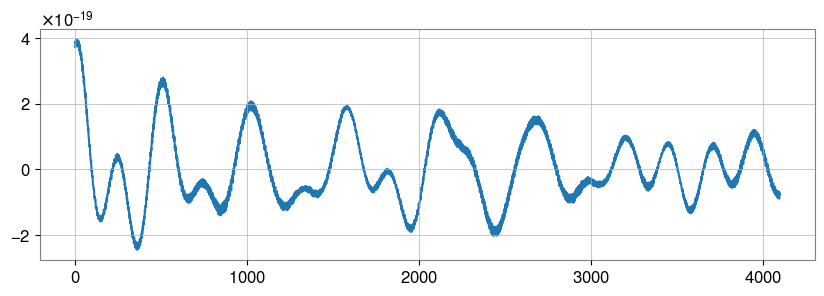

[0. 0. 0. ... 0. 0. 0.]
[-2.78917676e-27  1.73241067e-27  1.07678749e-26 ...
 -7.40735106e-28  2.70547708e-27  2.60273134e-27]
[-2.78917676e-27  1.73241067e-27  1.07678749e-26 ...
 -7.40735106e-28  2.70547708e-27  2.60273134e-27]
[-2.78917676e-27  1.73241067e-27  1.07678749e-26 ...
 -7.40735106e-28  2.70547708e-27  2.60273134e-27]
[-2.78917676e-27  1.73241067e-27  1.07678749e-26 ...
 -7.40735106e-28  2.70547708e-27  2.60273134e-27]


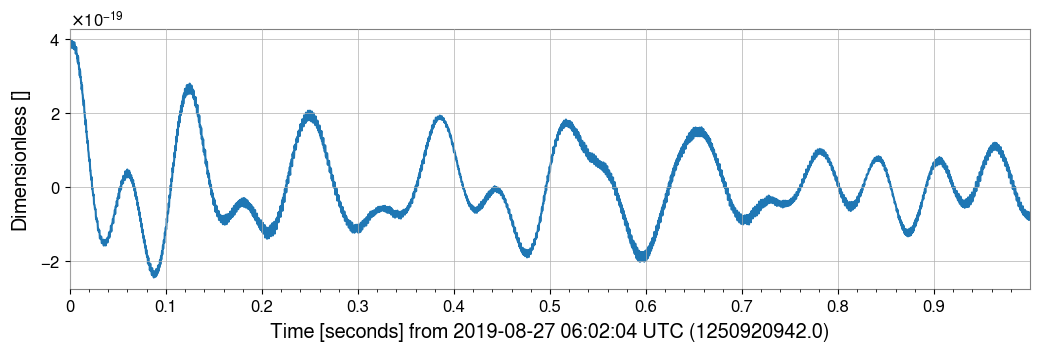

In [3]:
data_dir = f"/home/chiajui.chou/deepclean/data"
training_data = f"{data_dir}/O3_AC_train_H1-1250916844-12288.hdf5"
train_dir = f"/home/chiajui.chou/deepclean/results/train-O3-H1-kernel_1_1_st_0p5_epad_0p2_fpad_0p8_lr_0p2_oclr/lightning_logs/version_0"

ifo = "H1"
hoft_dir = f"/home/chiajui.chou/ll_data_O4_review/kafka/{ifo}"
lldetchar_dir = f"/home/chiajui.chou/ll_data_O4_review/lldetchar/{ifo}"

train_start, train_duration = 1250916844, 4096
test_start = train_start + train_duration
t0 = test_start + 2

with open(f"{train_dir}/config.yaml", 'r') as file:
    train_config = yaml.safe_load(file)
with open(f"{train_dir}/hparams.yaml", 'r') as file:
    train_hparams = yaml.safe_load(file)
with open(f"./config_clean.yaml", 'r') as file:
    clean_config = yaml.safe_load(file)

strain_channel = train_config['data']['channels'][0]
witness_channels = train_config['data']['channels'][1:]

fs = 4096
start = 4096+2 
stop = start + 1
with h5py.File(training_data, 'r') as f:
    raw_strain = f['H1:GDS-CALIB_STRAIN'][start*fs:stop*fs]
plt.figure(figsize=[10,3])
plt.plot(raw_strain)
plt.show()

hoft_tss = []
lldetchar_tss = []
for t in range(t0, t0+3):
    hoft = glob.glob(f"{hoft_dir}/*-{t}-*.gwf")
    ts = TimeSeries.read(hoft, strain_channel)
    hoft_tss.append(ts)
    lldetchar = glob.glob(f"{lldetchar_dir}/*-{t}-*.gwf")
    ts_dict = TimeSeriesDict.read(lldetchar, witness_channels)
    lldetchar_tss.append(ts_dict)

hoft_buffer = hoft_tss[0]
hoft_buffer[0*fs:1*fs].plot().show()

print(raw_strain - hoft_buffer[0*fs:1*fs].value)

hoft_tensor = torch.Tensor(hoft_buffer.value, device='cpu')
print(raw_strain - hoft_tensor[0*fs:1*fs].numpy())
print(raw_strain - hoft_tensor[0*fs:1*fs].double().numpy())
print(raw_strain - hoft_tensor[0*fs:1*fs].to('cuda').cpu().numpy())
print(raw_strain - hoft_tensor[0*fs:1*fs].to('cuda').double().cpu().numpy())

## Online

In [4]:
ifo = "H1"
hoft_dir = f"/home/chiajui.chou/ll_data_O4_review/kafka/{ifo}"
lldetchar_dir = f"/home/chiajui.chou/ll_data_O4_review/lldetchar/{ifo}"

train_start, train_duration = 1250916844, 4096
test_start = train_start + train_duration
t0 = test_start + 2
strain_channel = train_config['data']['channels'][0]
witness_channels = train_config['data']['channels'][1:]

hoft_tss = []
lldetchar_tss = []
for t in range(t0, t0+3):
    hoft = glob.glob(f"{hoft_dir}/*-{t}-*.gwf")
    ts = TimeSeries.read(hoft, strain_channel)
    hoft_tss.append(ts)
    lldetchar = glob.glob(f"{lldetchar_dir}/*-{t}-*.gwf")
    ts_dict = TimeSeriesDict.read(lldetchar, witness_channels)
    lldetchar_tss.append(ts_dict)

hoft_buffer = hoft_tss[0]
lldetchar_buffer = lldetchar_tss[0]
for hoft, lldetchar in zip(hoft_tss[1:], lldetchar_tss[1:]):
    hoft_buffer = hoft_buffer.append(hoft)
    lldetchar_buffer = lldetchar_buffer.append(lldetchar)

print(hoft_buffer.t0)
print(hoft_buffer.duration)
keys = list(lldetchar_buffer.keys())
print(lldetchar_buffer[keys[20]].t0)
print(lldetchar_buffer[keys[20]].duration)

1250920942.0 s
3.0 s
1250920942.0 s
3.0 s


In [5]:
device = "cuda"
sample_rate = clean_config['sample_rate']
outdir = clean_config['outdir']
train_dir = clean_config['train_dir']

train_start, train_duration = 1250916844, 4096
test_start = train_start + train_duration
t0 = test_start + 2

# InferenceModel
inference_model = InferenceModel(
    train_dir=train_dir,
    sample_rate=sample_rate,
    device=device,
)

# DeepCleanInferenceDataset
hoft_dir = clean_config['hoft_dir']
witness_dir = clean_config['witness_dir']
batch_size = 32
inference_sampling_rate = 2
kernel_size = 1
inference_dataset = DeepCleanInferenceDataset(
    hoft_dir=hoft_dir,
    witness_dir=witness_dir,
    model=inference_model,
    device=device,
)

# OnlineInference
online_infer = OnlineInference(
    model=inference_model,
    device=device,
    dataset=inference_dataset,
    outdir=outdir,
)

### FrameCrawler

In [5]:
hoft_crawler = FrameCrawler(Path(hoft_dir))
witness_crawler = FrameCrawler(Path(witness_dir))
channels_ordered_list = [strain_channel] + witness_channels
frame_iterator = frame_it(
    hoft_crawler,
    witness_crawler,
    channels_ordered_list,
    sample_rate
)
strain_fname, craw_strain, craw_witnesses = next(frame_iterator)

NameError: name 'witness_dir' is not defined

/home/chiajui.chou/ll_data_O4_review/kafka/H1/H-H1_llhoft-1250920943-1.gwf
4096.0 Hz
4096.0 Hz
TimeSeries([0., 0., 0., ..., 0., 0., 0.]
           unit: dimensionless,
           t0: 1250920942.0 s,
           dt: 0.000244140625 s,
           name: None,
           channel: None)


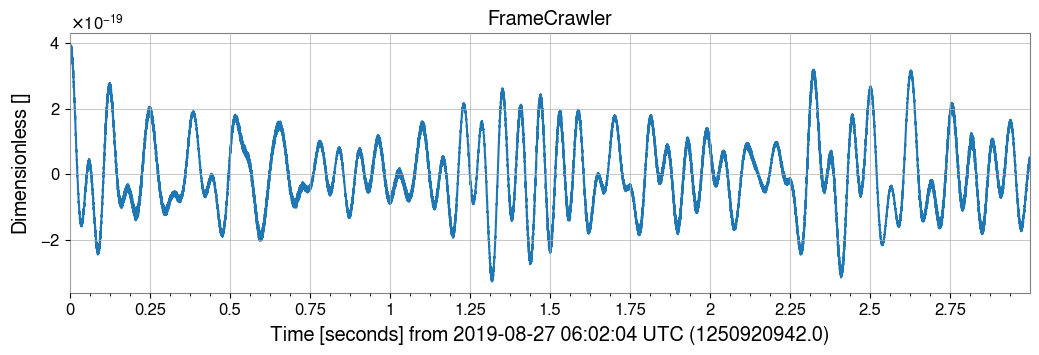

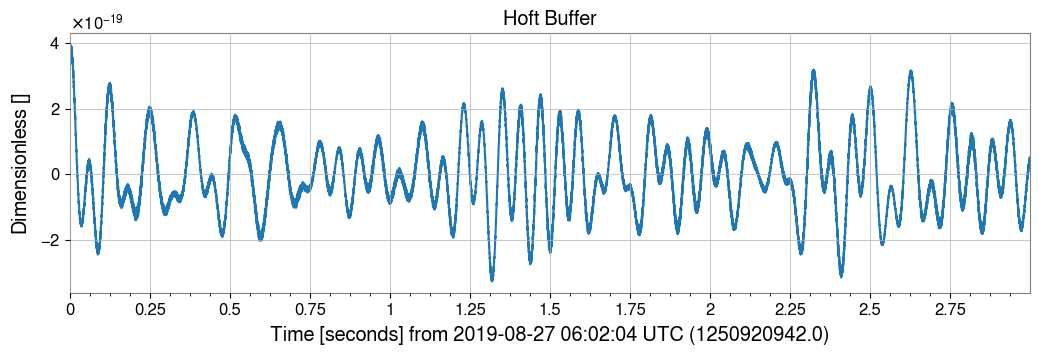

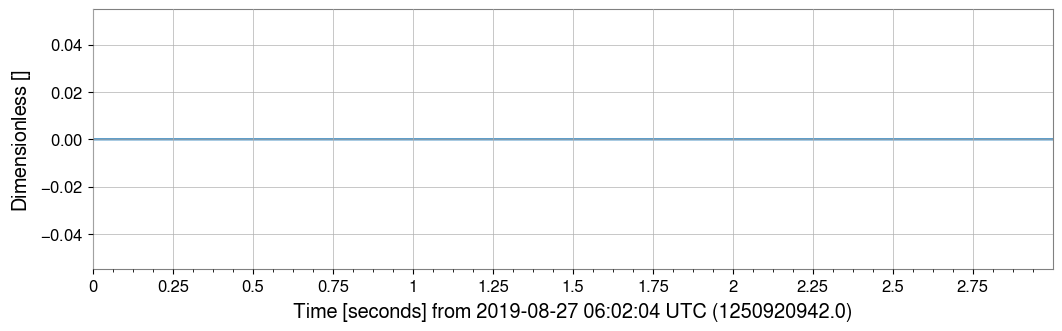

In [7]:
print(strain_fname)
craw_strain_ts = TimeSeries(
    craw_strain,
    t0=1250920942,
    sample_rate=sample_rate,
)
print(craw_strain_ts.sample_rate)
print(hoft_buffer.sample_rate)
print(craw_strain_ts - hoft_buffer)
craw_strain_ts.plot(title='FrameCrawler').show()
hoft_buffer.plot(title='Hoft Buffer').show()
(craw_strain_ts - hoft_buffer).plot().show()

In [8]:
print(inference_dataset.X_inference.X.shape, inference_dataset.X_inference.stride)
print(inference_dataset.y_inference.X.shape, inference_dataset.y_inference.stride)

batches = []
for X_batch, y_batch in zip(iter(inference_dataset.X_inference), iter(inference_dataset.y_inference)):
    batches.append([X_batch, y_batch])

print(len(batches))
for batch in batches:
    print(batch[0].shape)
    print(batch[1].shape)

torch.Size([21, 12288]) 2048
torch.Size([12288]) 4096
1
torch.Size([5, 21, 4096])
torch.Size([3, 4096])


tensor([3.7260e-19, 3.7374e-19, 3.9010e-19,  ..., 4.8944e-20, 4.6474e-20,
        4.5198e-20], dtype=torch.float64)


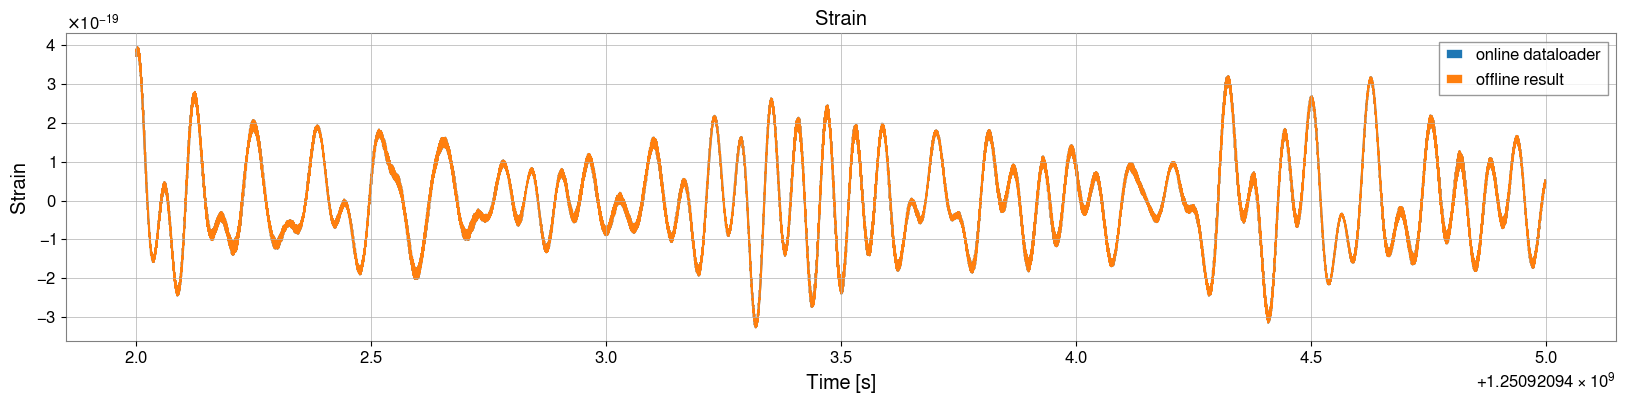

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


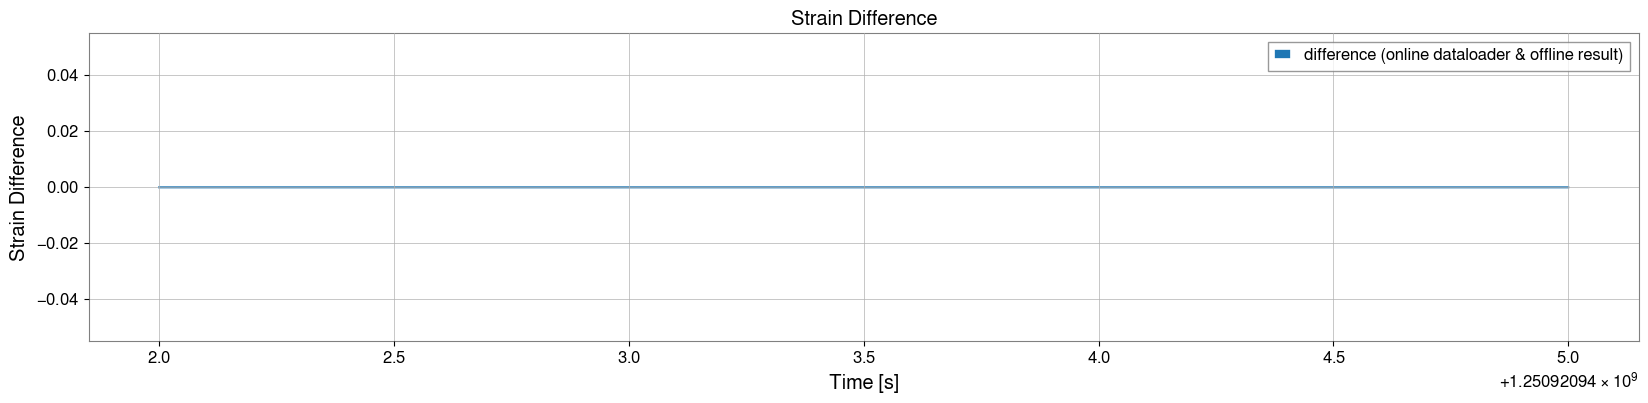

In [8]:
print(inference_dataset.y_inference.X.double().to('cpu'))

output_file = f"{train_dir}/test/outputs.hdf5"
with h5py.File(output_file, 'r') as f:
    # print(f.keys())
    noise_strain = f['noise'][0][:]
    raw_strain = f['strain'][0][:]
fs = 4096
st = int((1)*fs)
ed = st + 3*fs
offline_raw = raw_strain[st:ed]

times = np.arange(t0, t0+3, 1/fs)
plt.figure(figsize=[20,4])
plt.title('Strain')
plt.plot(times, inference_dataset.y_inference.X.double().to('cpu').numpy(), label='online dataloader')
plt.plot(times, offline_raw, label='offline result')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.legend()
plt.show()

print(inference_dataset.y_inference.X.double().to('cpu') - offline_raw)
plt.figure(figsize=[20,4])
plt.title('Strain Difference')
plt.plot(times, inference_dataset.y_inference.X.double().to('cpu').numpy() - offline_raw, label='difference (online dataloader & offline result)')
plt.xlabel('Time [s]')
plt.ylabel('Strain Difference')
plt.legend()
plt.show()

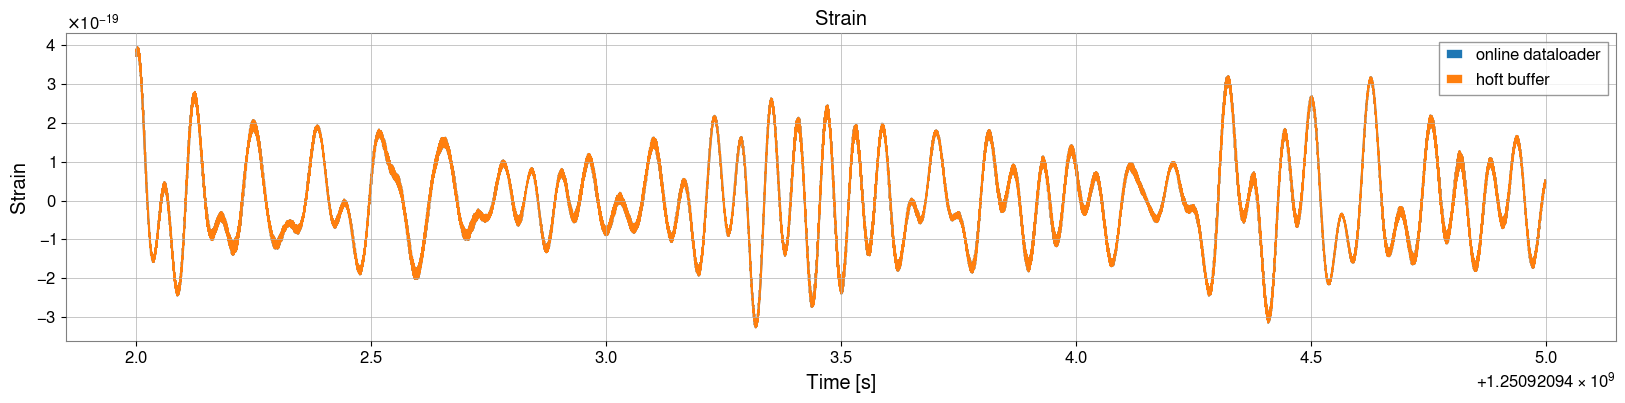

[ 2.78917676e-27 -1.73241067e-27 -1.07678749e-26 ...
  4.73637566e-28  1.17710380e-27 -1.63991851e-28]


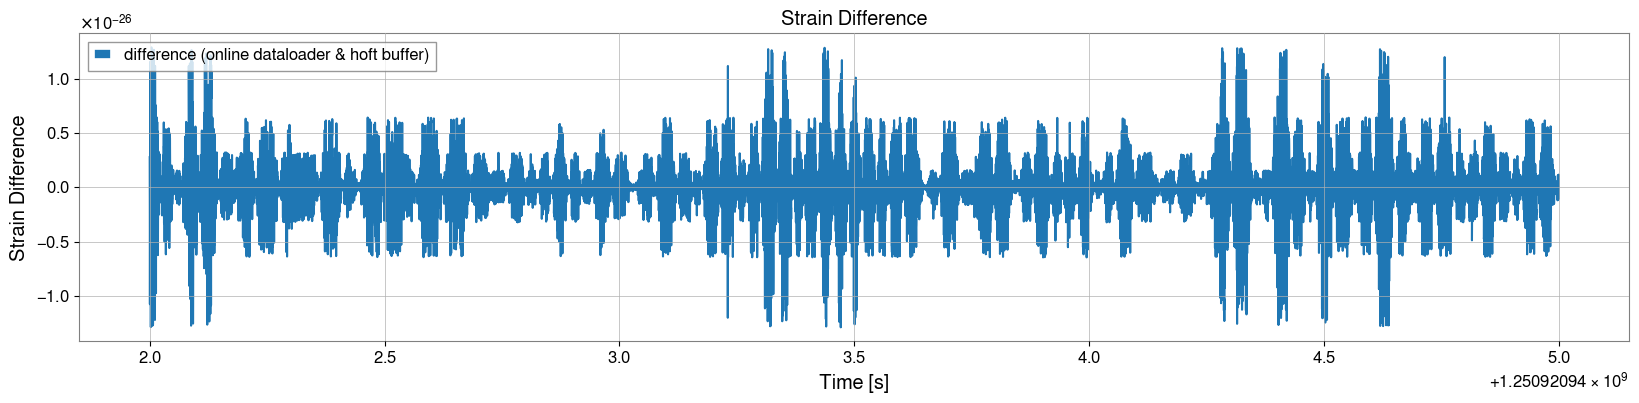

[-2.78917676e-27  1.73241067e-27  1.07678749e-26 ...
 -4.73637566e-28 -1.17710380e-27  1.63991851e-28]


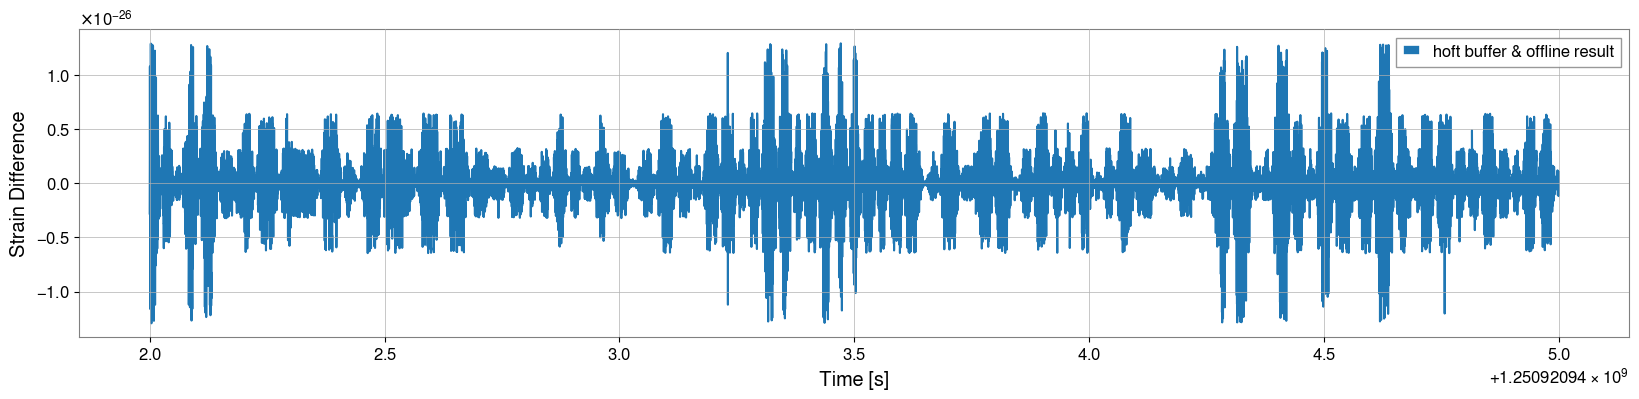

In [9]:
# hoft_buffer.plot(figsize=[20,4]).show()
plt.figure(figsize=[20,4])
plt.title('Strain')
plt.plot(times, inference_dataset.y_inference.X.double().to('cpu').numpy(), label='online dataloader')
plt.plot(times, hoft_buffer.value, label='hoft buffer')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.legend()
plt.show()

print(inference_dataset.y_inference.X.double().to('cpu').numpy() - hoft_buffer.value)
plt.figure(figsize=[20,4])
plt.title('Strain Difference')
plt.plot(times, inference_dataset.y_inference.X.double().to('cpu').numpy() - hoft_buffer.value, label='difference (online dataloader & hoft buffer)')
plt.xlabel('Time [s]')
plt.ylabel('Strain Difference')
plt.legend()
plt.show()

print(hoft_buffer.value - offline_raw)
plt.figure(figsize=[20,4])
plt.plot(hoft_buffer.times, hoft_buffer.value - offline_raw, label='hoft buffer & offline result')
plt.xlabel('Time [s]')
plt.ylabel('Strain Difference')
plt.legend()
plt.show()

## Offline Metrics

In [6]:
device = "cuda"
sample_rate = clean_config['sample_rate']
train_start = 1250916844

# Dataset
fname = train_config['data']['fname']
channels = train_config['data']['channels']
train_duration = train_config['data']['train_duration']
# test_duration = train_config['data']['test_duration']
test_duration = 8192
train_stride = train_config['data']['train_stride']
valid_frac = train_config['data']['valid_frac']
inference_sampling_rate = train_config['data']['inference_sampling_rate']
batch_size = train_config['data']['batch_size']
kernel_length = train_config['data']['kernel_length']
freq_low = train_config['data']['freq_low']
freq_high = train_config['data']['freq_high']
filt_order = train_config['data']['filt_order']

test_start = train_start + train_duration

# Model
edge_pad = train_config['model']['metric']['init_args']['edge_pad']
filter_pad = train_config['model']['metric']['init_args']['filter_pad']
hidden_channels = train_config['model']['arch']['init_args']['hidden_channels']
num_witnesses = len(train_hparams['channels']) - 1

y_scaler = ChannelWiseScaler()
y_scaler.load_state_dict(torch.load(f"{train_dir}/y_scaler.pt"))
bandpass = BandpassFilter(
    freq_low,
    freq_high,
    sample_rate,
    filt_order
)

In [7]:
offline_dataset = DeepCleanDataset(
    fname=fname,
    channels=channels,
    kernel_length=kernel_length,
    freq_low=freq_low,
    freq_high=freq_high,
    batch_size=batch_size,
    train_duration=train_duration,
    test_duration=test_duration,
    valid_frac=valid_frac,
    train_stride=train_stride,
    inference_sampling_rate=inference_sampling_rate,
)
arch = Autoencoder(
    num_witnesses=num_witnesses,
    hidden_channels=hidden_channels,
)
loss = PsdRatio(
    sample_rate=sample_rate,
    fftlength=1,
    freq_low=freq_low,
    freq_high=freq_high,
    asd=True,
)
metric = OnlinePsdRatio(
    inference_sampling_rate=inference_sampling_rate,
    edge_pad=edge_pad,
    filter_pad=filter_pad,
    sample_rate=sample_rate,
    bandpass=bandpass,
    y_scaler=y_scaler,
)
offline_model = DeepClean(
    arch=arch,
    loss=loss,
    metric=metric,
)
model = torch.jit.load(f"{train_dir}/model.pt")

### Setup

In [8]:
offline_dataset.setup(stage='fit')
offline_dataset.setup(stage='test')

In [9]:
test_dataloader = offline_dataset.test_dataloader()
print(len(test_dataloader))
print(test_dataloader.datasets[0].X.shape)
print(test_dataloader.datasets[0].kernel_size)
print(test_dataloader.datasets[0].stride)
print(test_dataloader.datasets[1].X.shape)
print(test_dataloader.datasets[1].kernel_size)
print(test_dataloader.datasets[1].stride)

print("All batches")
for i, data in enumerate(iter(test_dataloader)):
    print(i)
    print(data[0].shape)
    if data[1] != None:
        print(data[1].shape)
    else:
        print("All strain loaded.")

8
torch.Size([21, 33554432])
4096
2048
torch.Size([1, 33554432])
4096
4096
All batches
0
torch.Size([2048, 21, 4096])
torch.Size([2048, 1, 4096])
1
torch.Size([2048, 21, 4096])
torch.Size([2048, 1, 4096])


2
torch.Size([2048, 21, 4096])
torch.Size([2048, 1, 4096])
3
torch.Size([2048, 21, 4096])
torch.Size([2048, 1, 4096])
4
torch.Size([2048, 21, 4096])
All strain loaded.
5
torch.Size([2048, 21, 4096])
All strain loaded.
6
torch.Size([2048, 21, 4096])
All strain loaded.
7
torch.Size([2047, 21, 4096])
All strain loaded.


### Online and Offline:  Witness dataloader

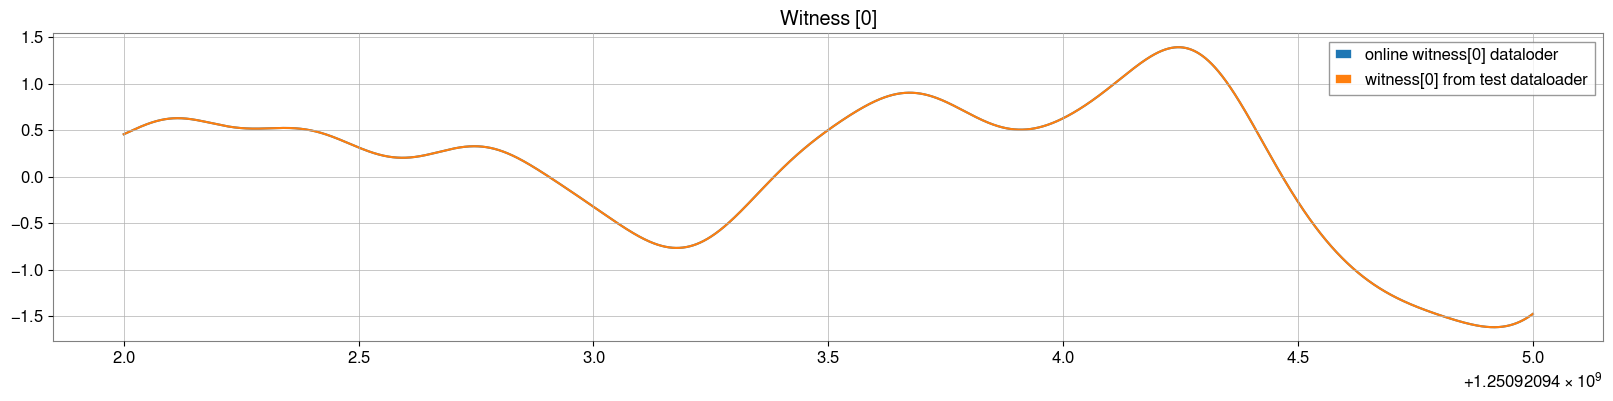

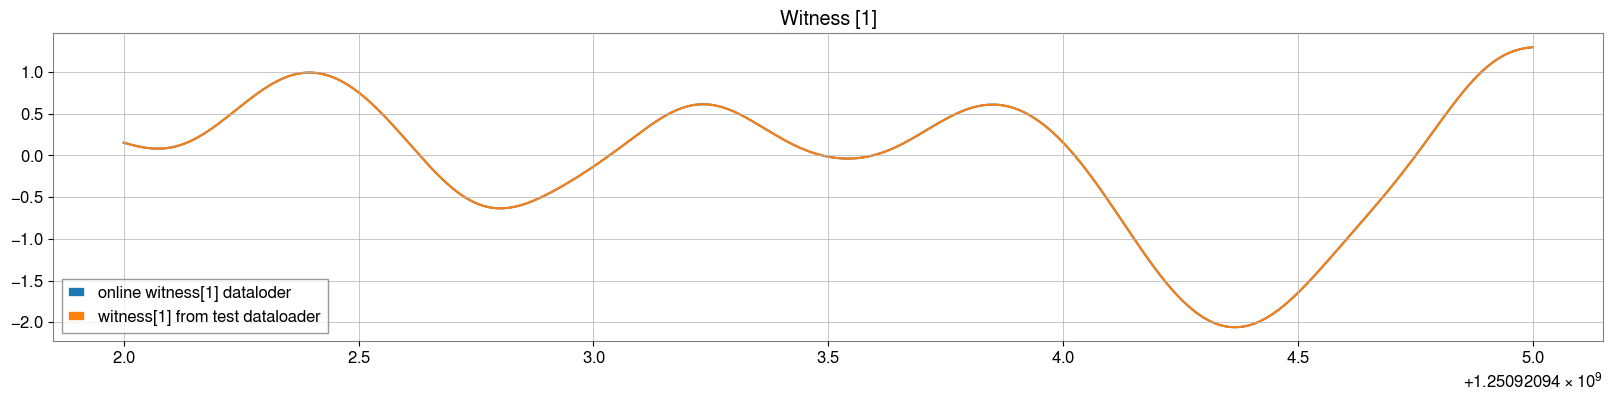

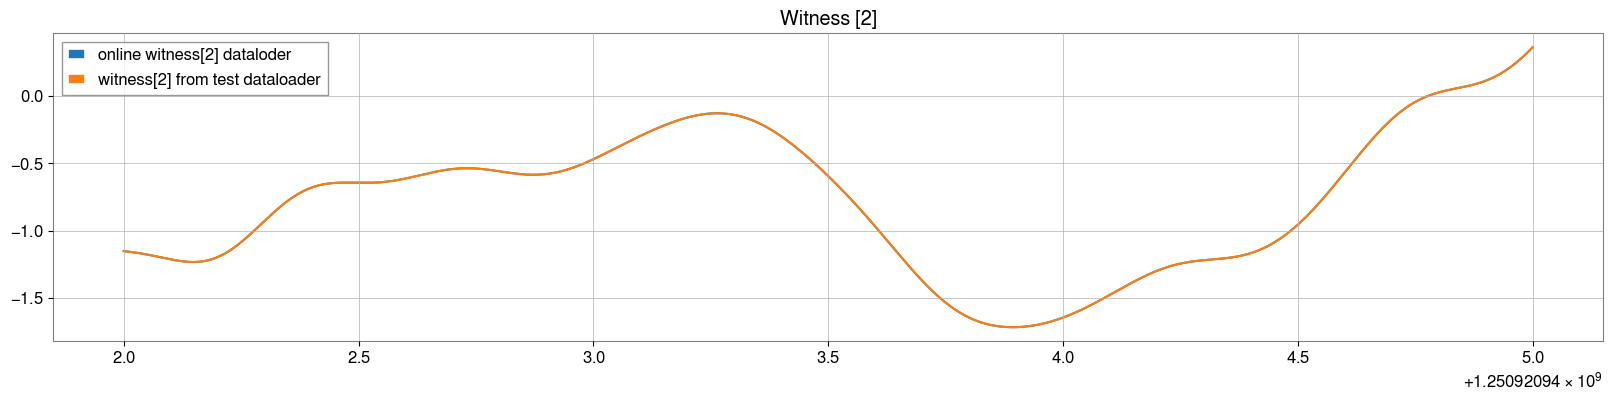

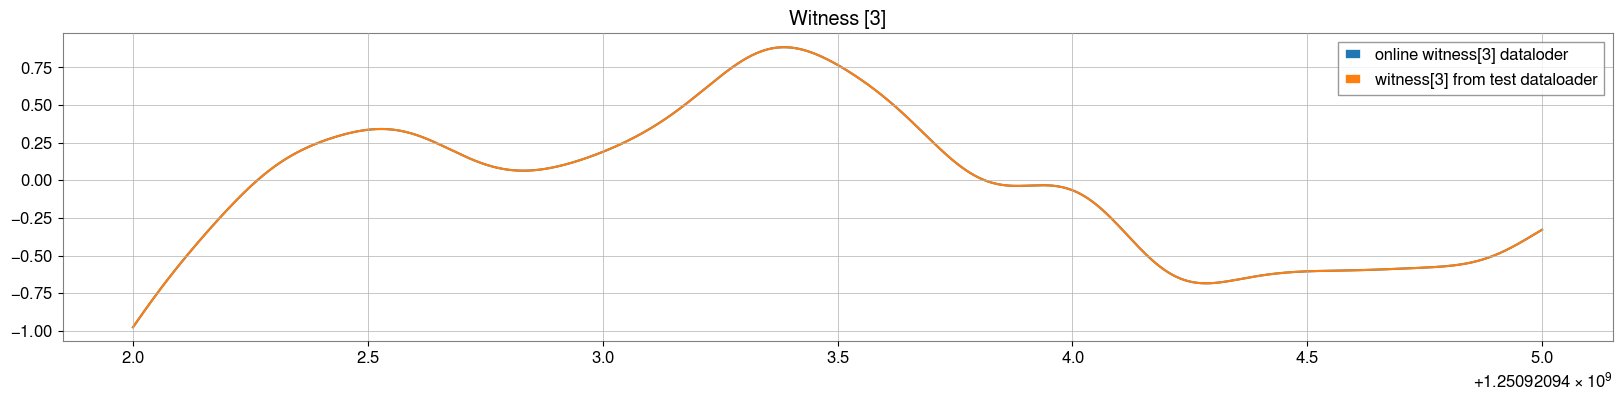

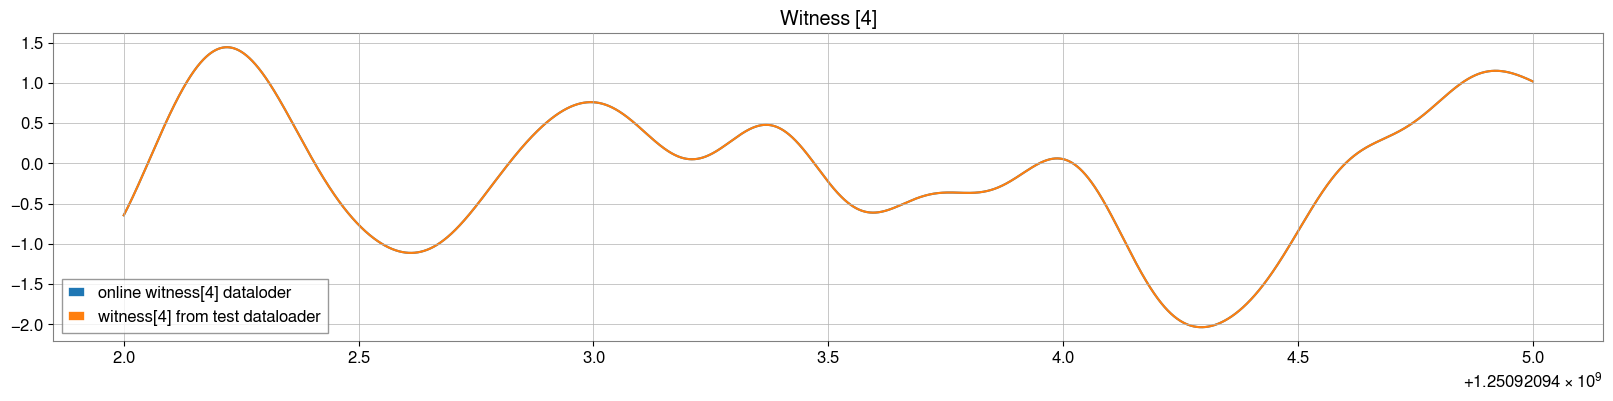

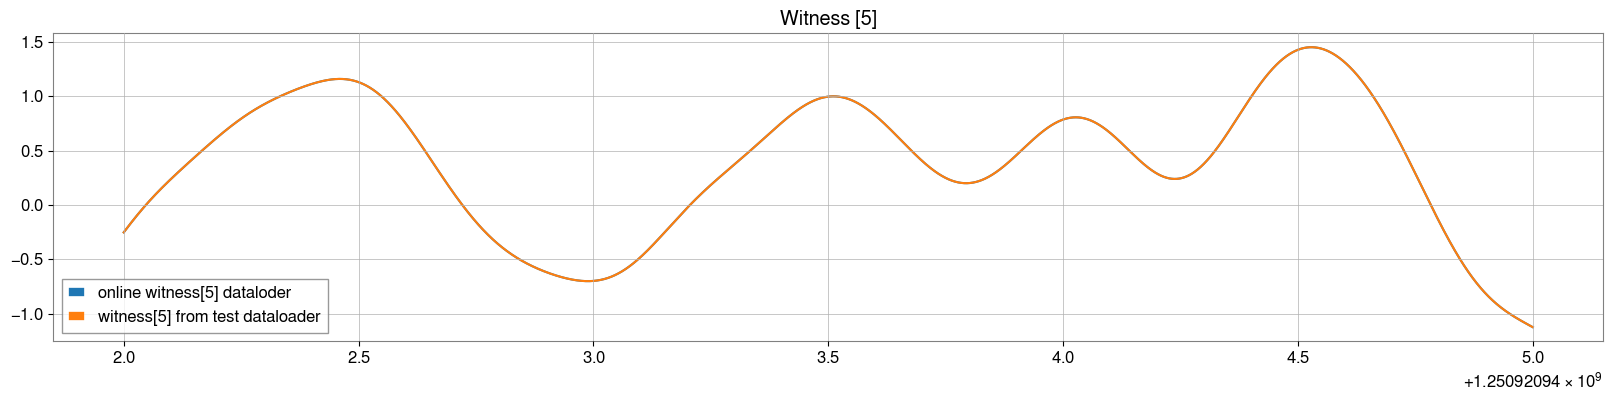

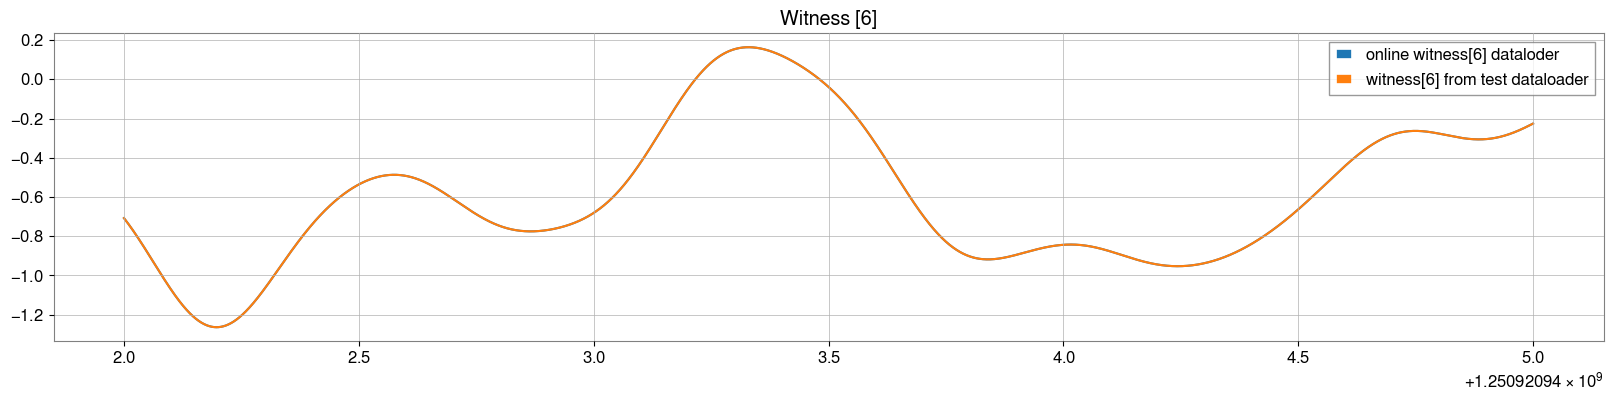

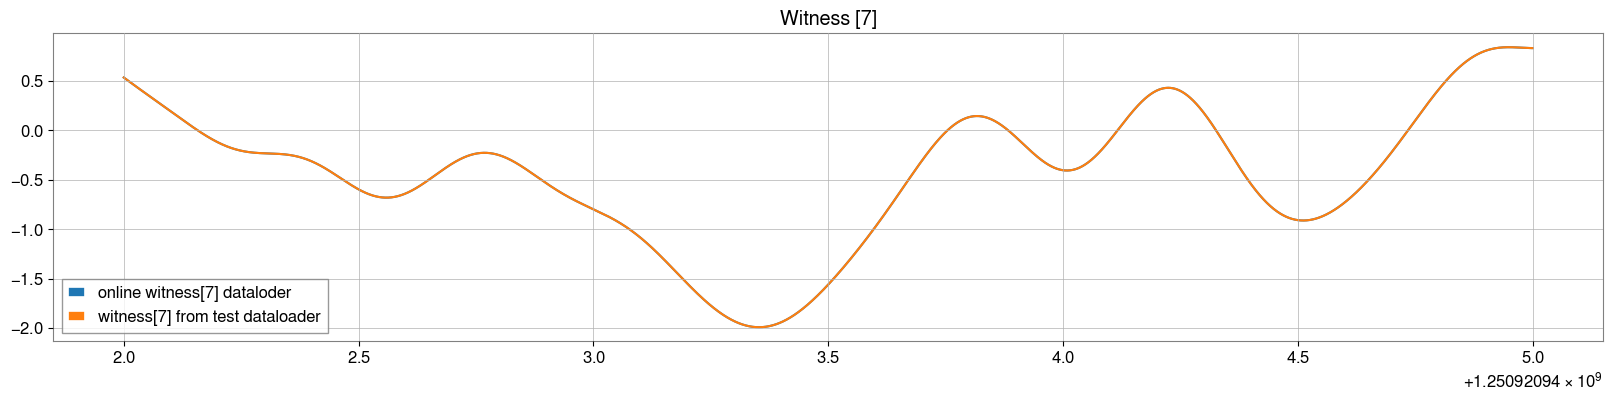

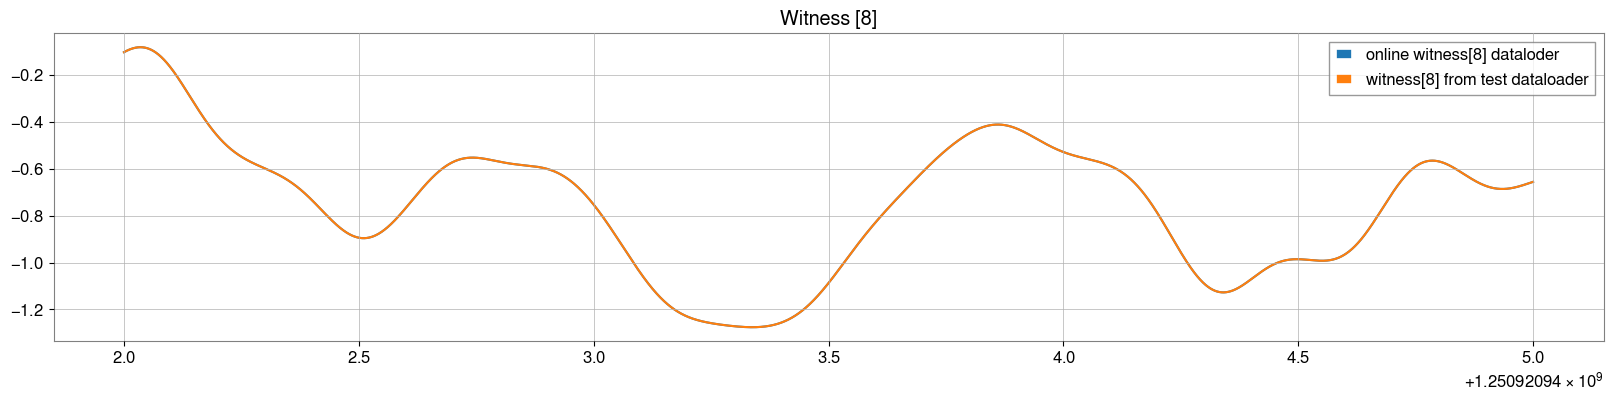

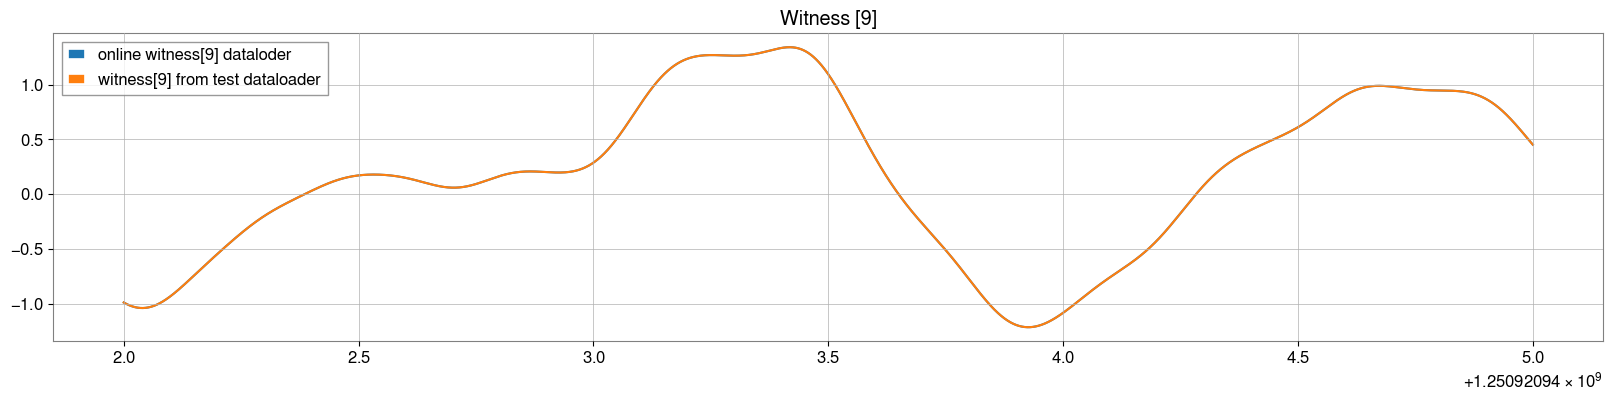

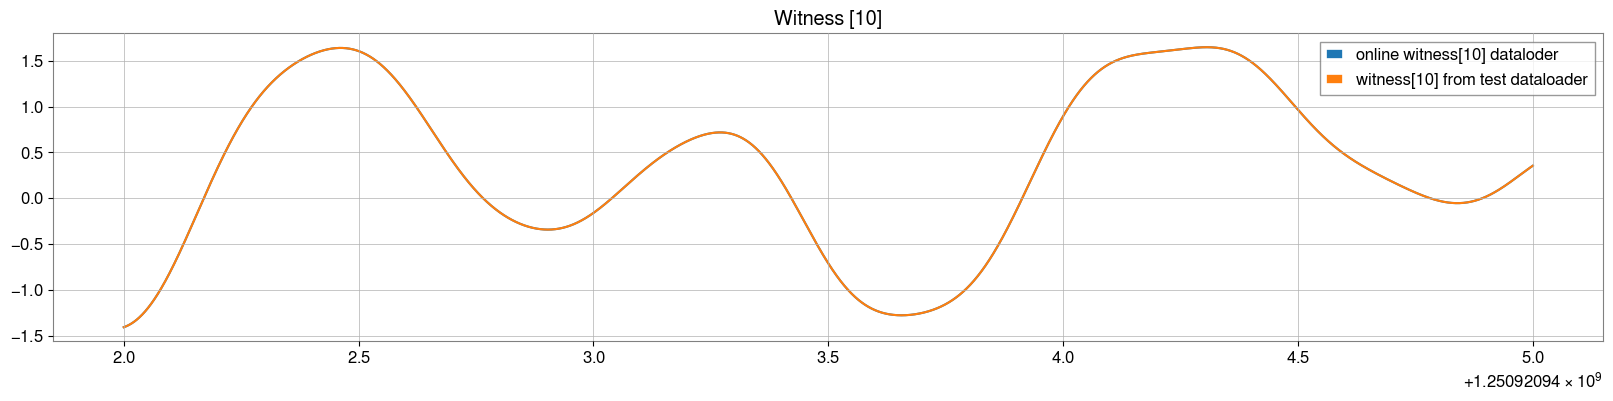

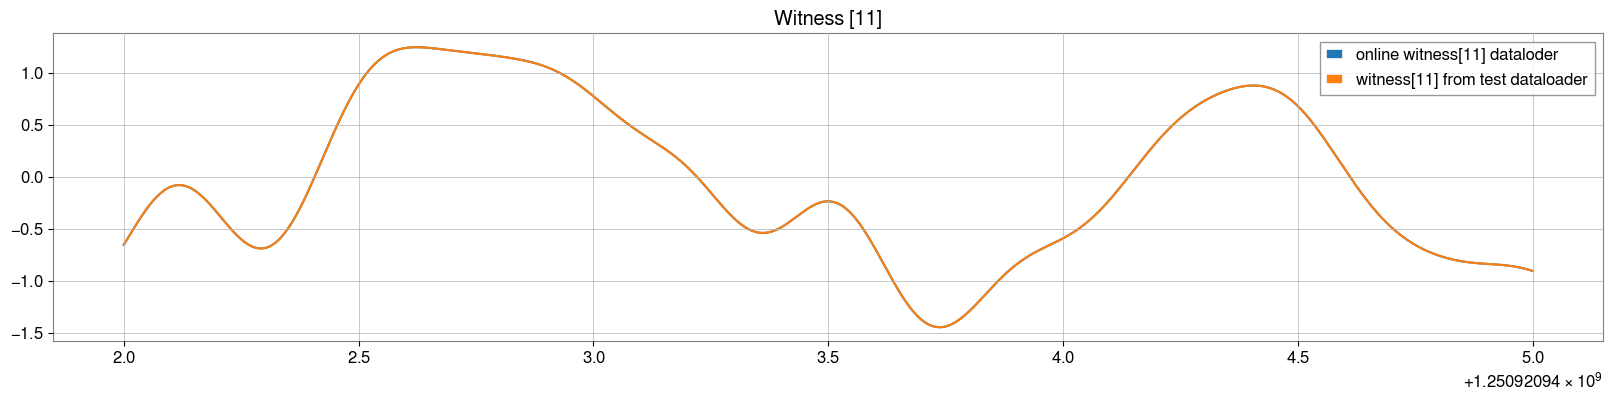

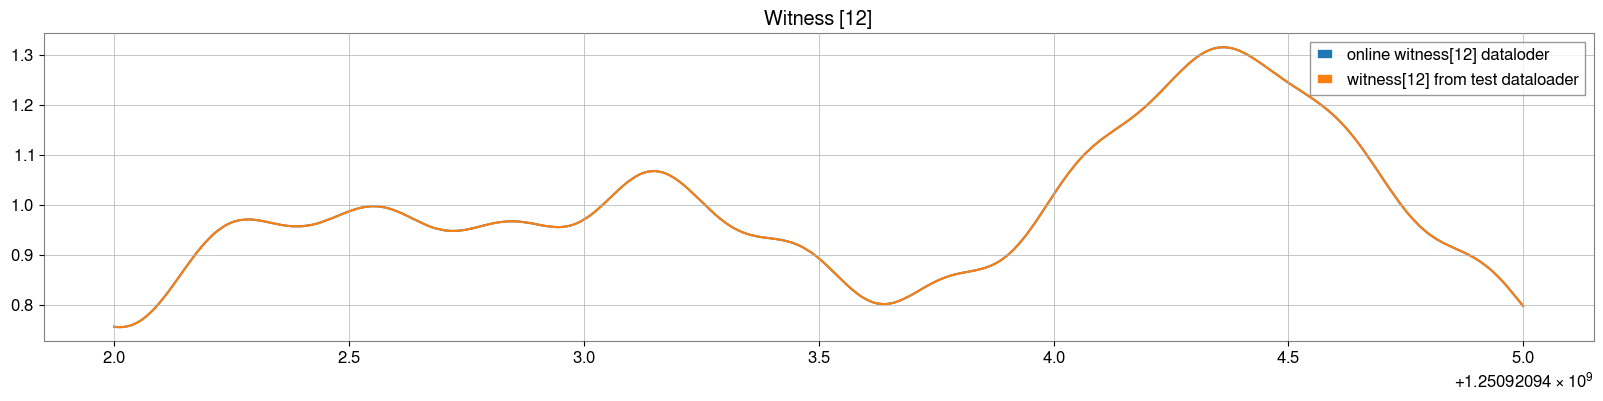

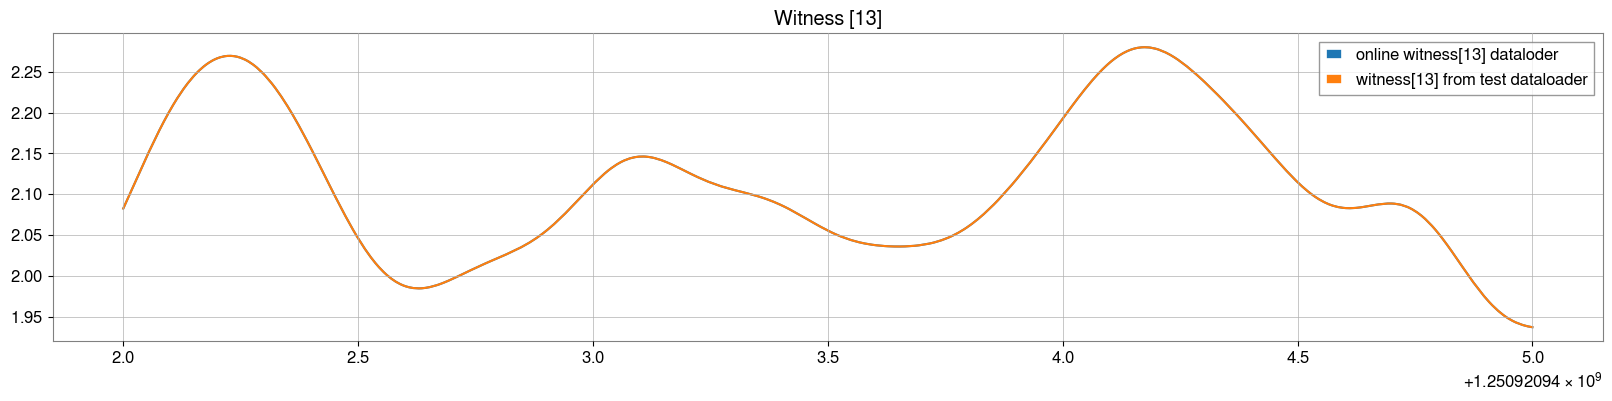

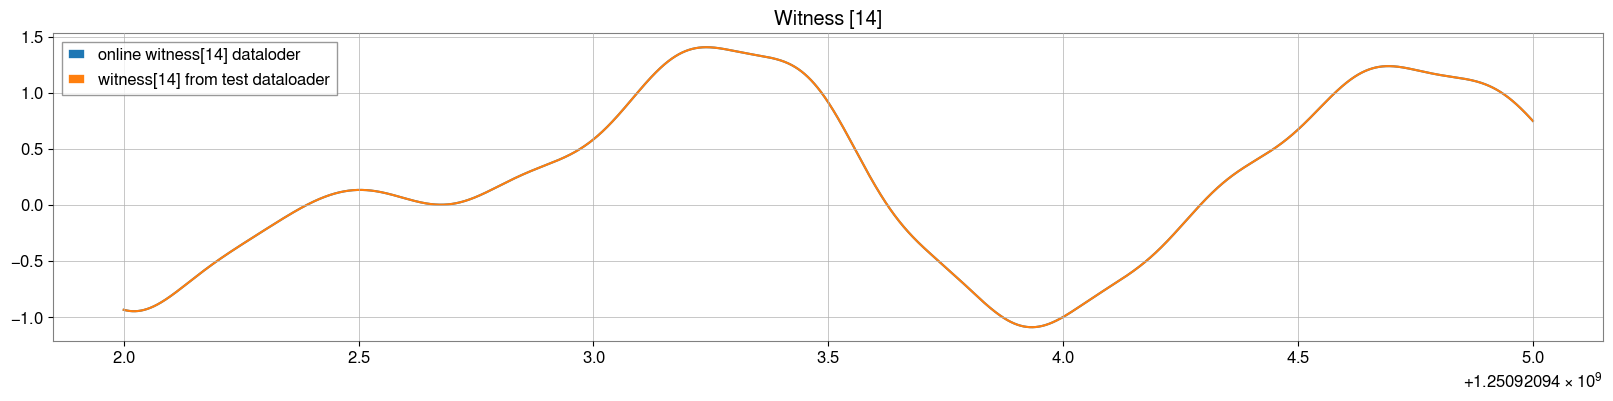

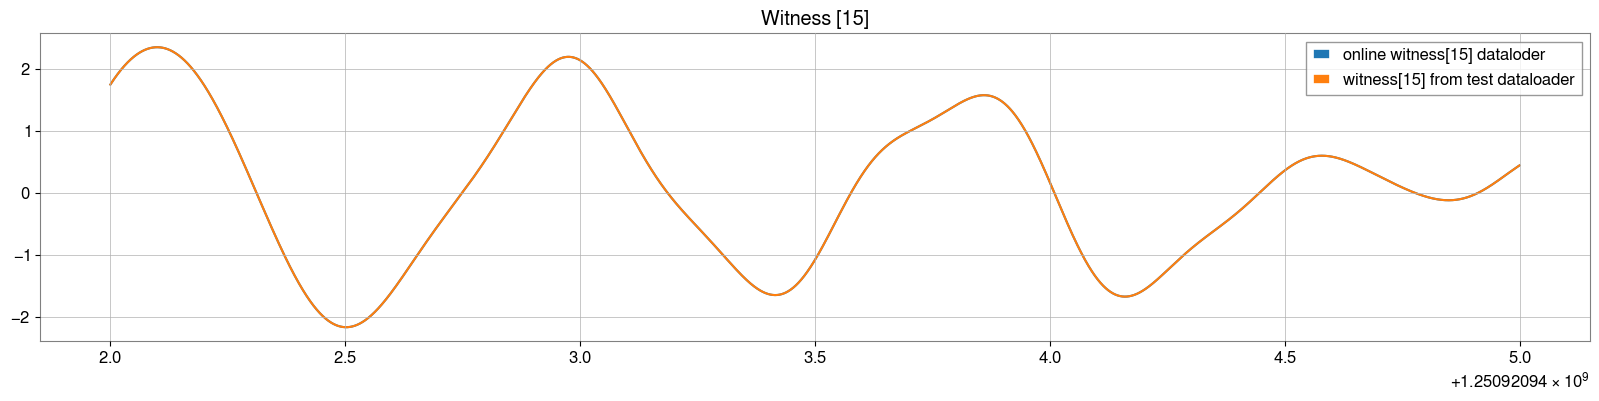

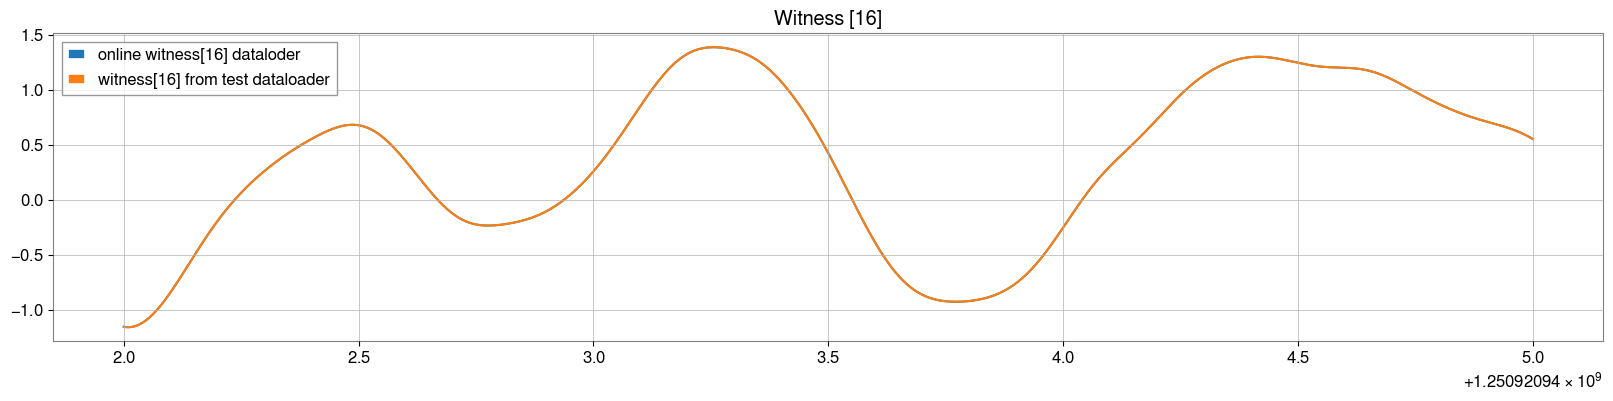

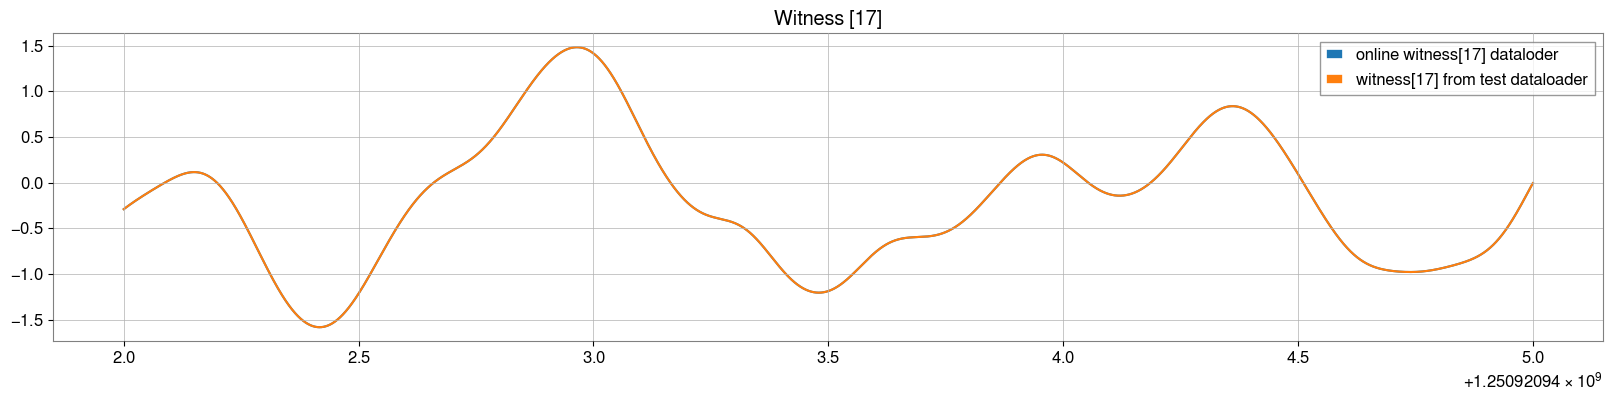

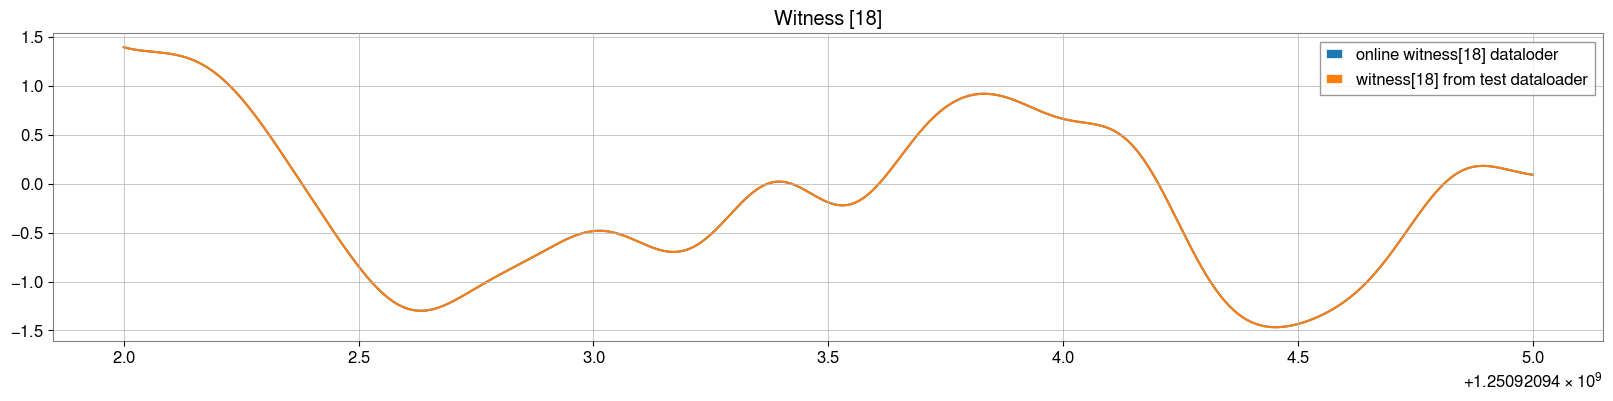

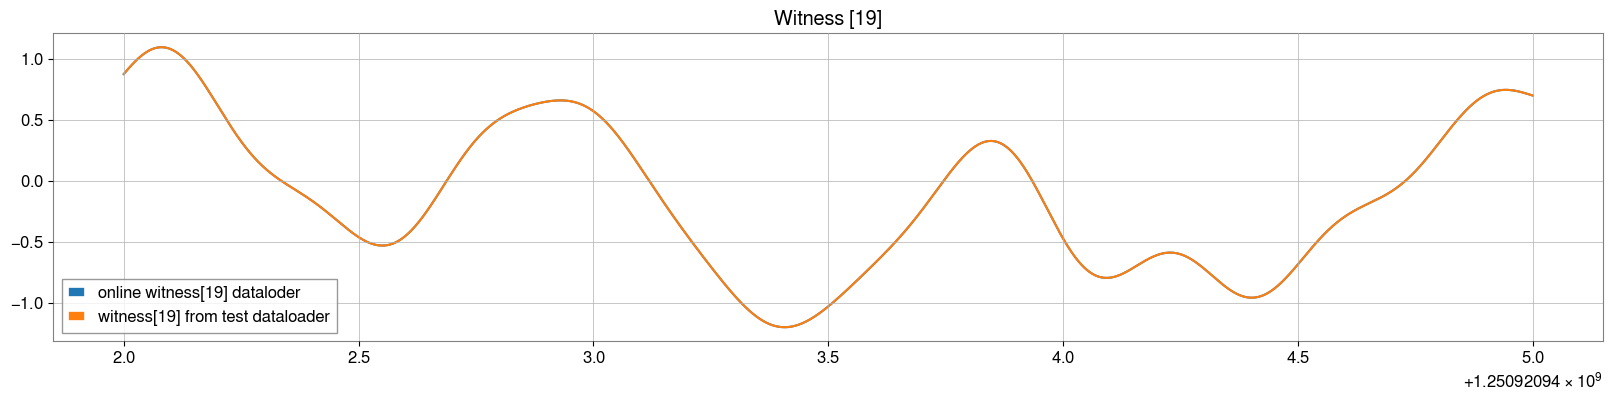

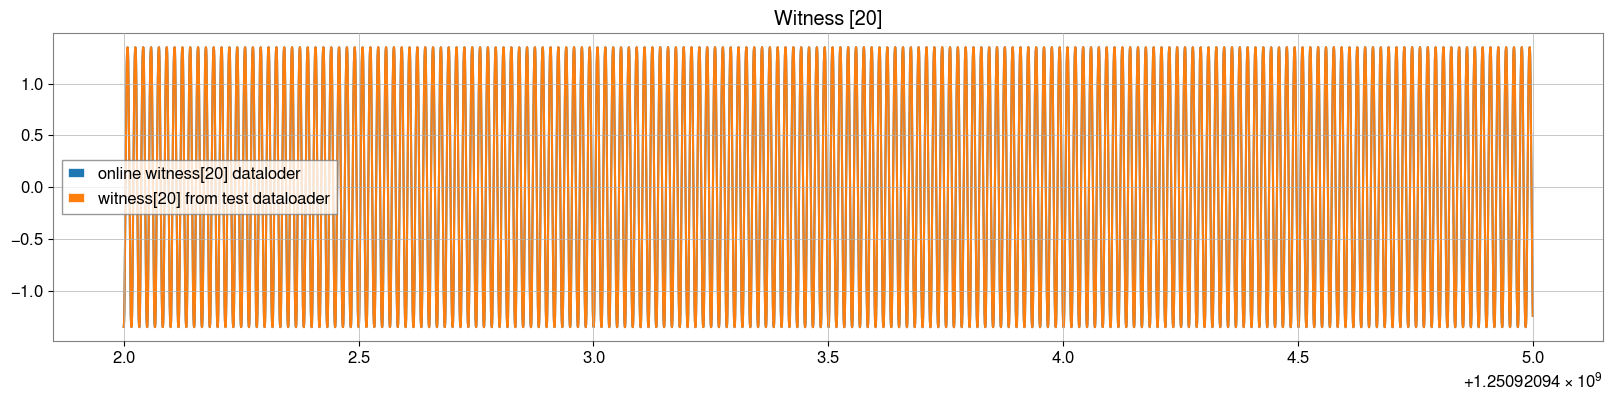

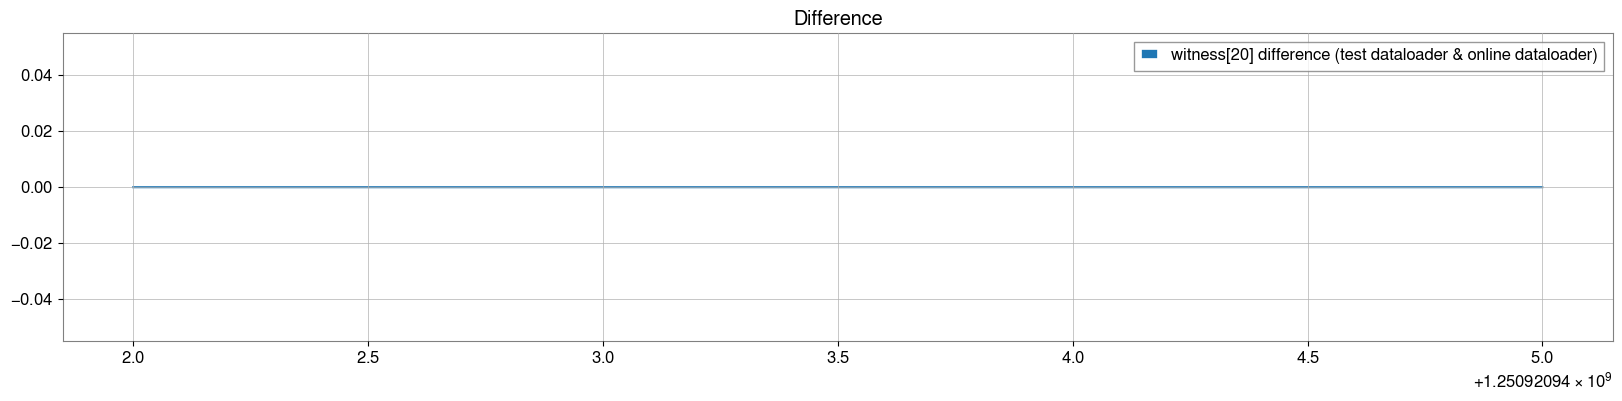

In [43]:
train_start, train_duration = 1250916844, 4096
test_start = train_start + train_duration
t0 = test_start + 2
fs = 4096

times = np.arange(t0, t0+3, 1/fs)
st = 2
wit_id = 20
for wit_id in range(21):
    # online witness dataloader
    online_wit = inference_dataset.X_inference.X[wit_id].double().to('cpu').numpy()
    # offline witness dataloader
    t_data_wit = test_dataloader.datasets[0].X[wit_id][st*fs:(st + 3)*fs].double().numpy()
    plt.figure(figsize=[20,4])
    plt.title(f'Witness [{wit_id}]')
    plt.plot(times, online_wit, label=f'online witness[{wit_id}] dataloder')
    plt.plot(times, t_data_wit, label=f'witness[{wit_id}] from test dataloader')
    plt.legend()
    plt.show()

# Difference
wit_id = 20
plt.figure(figsize=[20,4])
plt.title('Difference')
plt.plot(times, t_data_wit - online_wit, label=f'witness[{wit_id}] difference (test dataloader & online dataloader)')
plt.legend()
plt.show()

### Online and Offline:  Strain dataloader

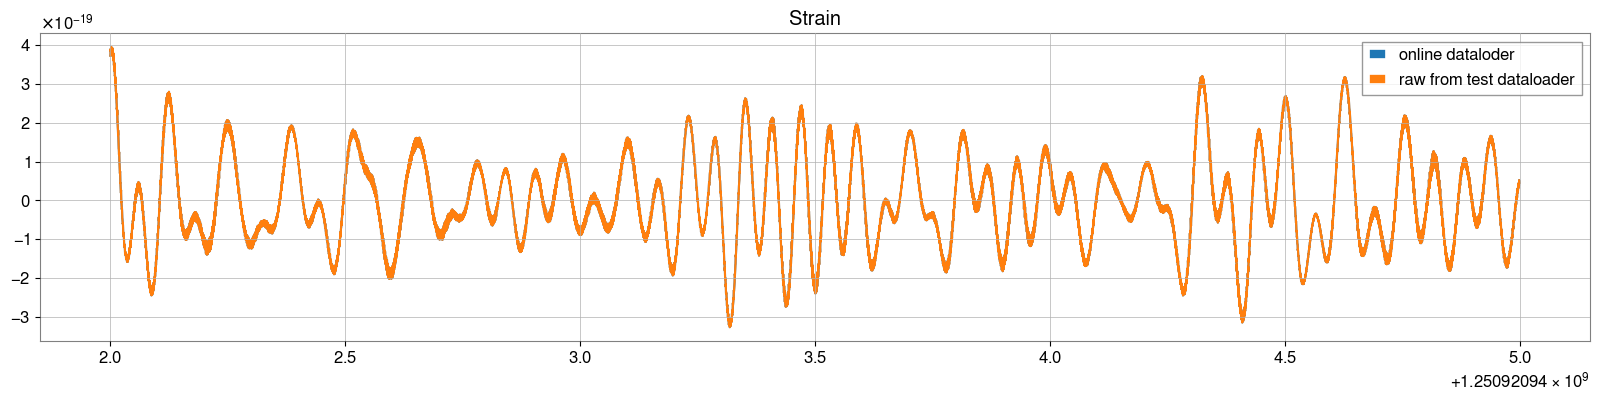

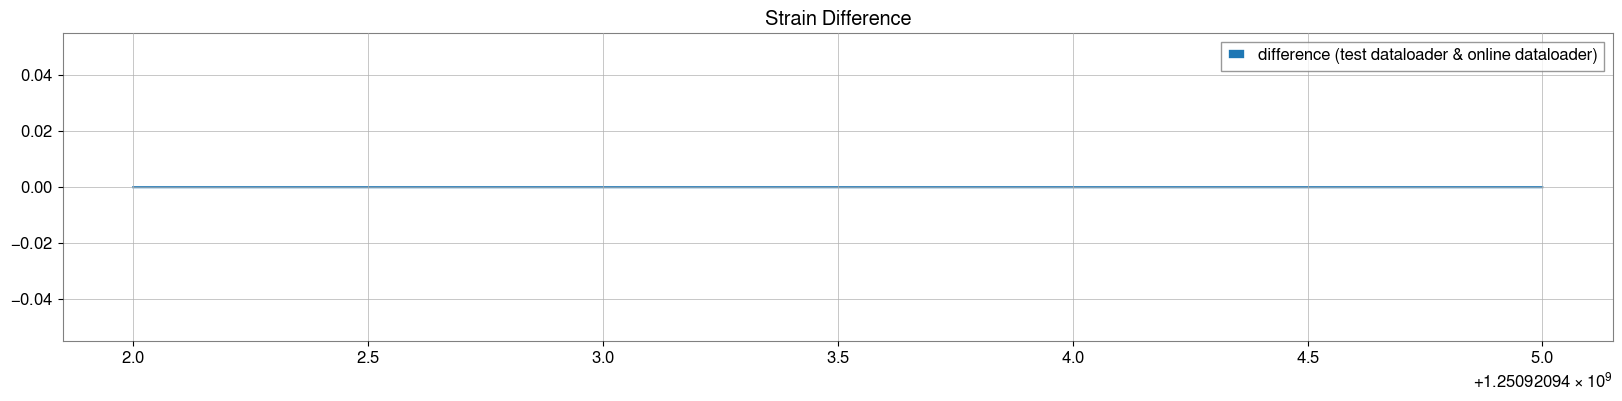

In [44]:
# print(test_dataloader.datasets[0].X.shape)
st = 2
online_raw = inference_dataset.y_inference.X.double().to('cpu').numpy()
t_data_raw = test_dataloader.datasets[1].X[0][st*fs:(st + 3)*fs].double().numpy()
plt.figure(figsize=[20,4])
plt.title('Strain')
plt.plot(times, online_raw, label='online dataloder')
plt.plot(times, t_data_raw, label='raw from test dataloader')
plt.legend()
plt.show()

plt.figure(figsize=[20,4])
plt.title('Strain Difference')
plt.plot(times, t_data_raw - online_raw, label='difference (test dataloader & online dataloader)')
plt.legend()
plt.show()

### Metric

In [10]:
test_dataloader = offline_dataset.test_dataloader()
batches = []
for i, batch in enumerate(iter(test_dataloader)):
    batches.append(batch)

print(len(metric.strain), len(metric.predictions))
print(metric.strain)
print(metric.predictions)

0 0
[]
[]


## offline_model._shared_eval_step, but using model from torch.jit.load.

In [11]:
# device = 'cuda'
for batch in batches[:]:
    witnesses, strain = batch
    if strain != None:
        # strain = strain.to(device)
        y_true = batch[1]
        metric.update(y_true[:, 0], "strain")
    if witnesses != None:
        # witnesses = witnesses.to(device)
        y_pred = model(witnesses)
        metric.update(y_pred, "predictions")

print(len(metric.strain), len(metric.predictions))
print(metric.strain[0].shape)
print(metric.predictions[0].shape)

4 8
torch.Size([2048, 4096])
torch.Size([2048, 4096])


In [12]:
noise_before_process, noise, raw = metric.clean()

torch.Size([1, 33542144]) torch.Size([1, 33542144])


/home/chiajui.chou/.cache/pypoetry/virtualenvs/clean-IeYuvgpU-py3.10/lib/python3.10/site-packages/gwpy/plot/axes.py:190: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)
/home/chiajui.chou/.cache/pypoetry/virtualenvs/clean-IeYuvgpU-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


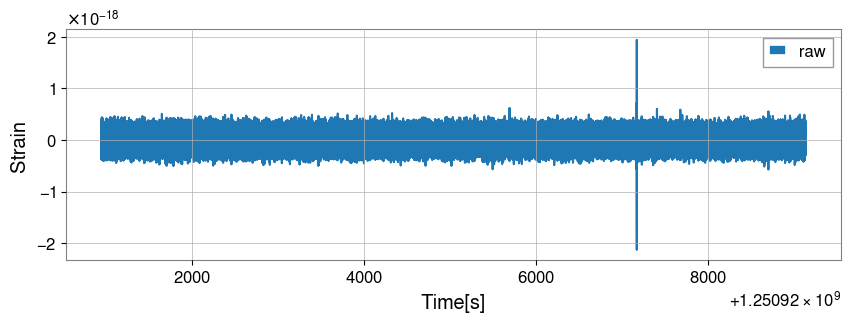

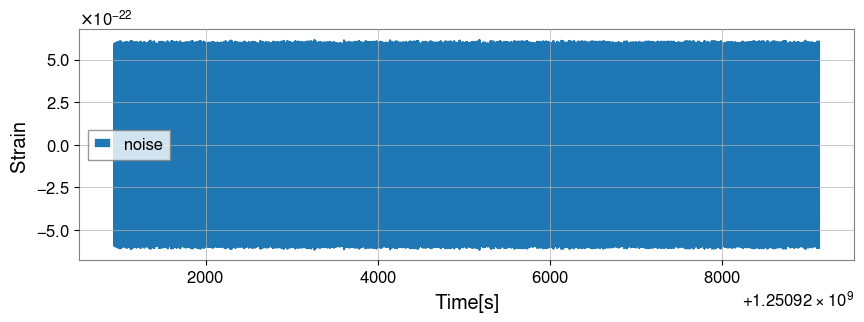

In [21]:
t0 = test_start + 1
times = np.arange(t0, t0+raw.shape[1]/sample_rate, 1/sample_rate)
print(raw.shape, noise.shape)

plt.figure(figsize=[10,3])
plt.plot(times, raw[0].numpy(), label='raw')
# plt.plot(times, noise[0].numpy(), label='noise')
plt.xlabel('Time[s]')
plt.ylabel('Strain')
plt.legend()
plt.show()

plt.figure(figsize=[10,3])
# plt.plot(times, raw[0].numpy(), label='raw')
plt.plot(times, noise[0].numpy(), label='noise')
plt.xlabel('Time[s]')
plt.ylabel('Strain')
plt.legend()
plt.show()

33542144
33542144


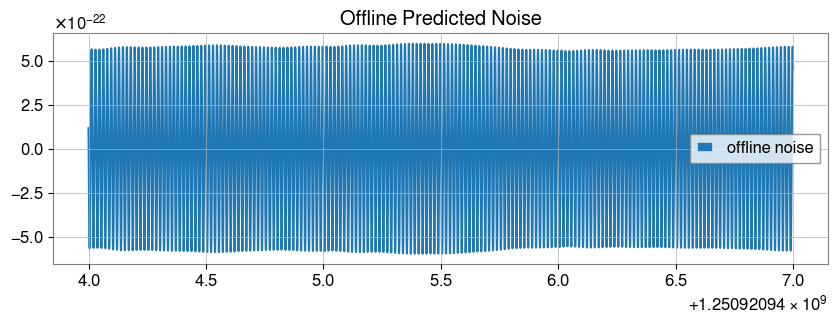

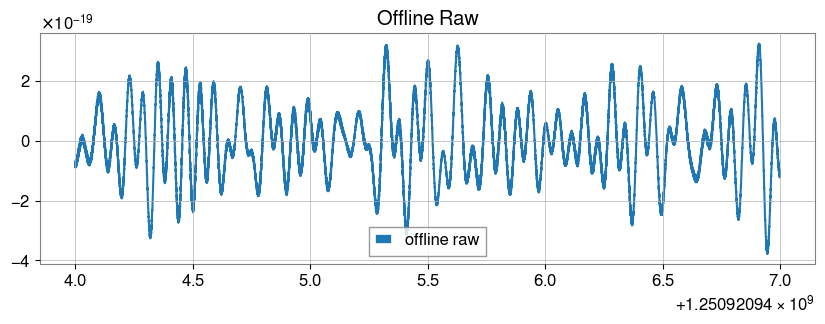

In [13]:
print(raw.shape[1])
print(noise.shape[1])
st = 2
times = np.arange(t0, t0+raw.shape[1]/sample_rate, 1/sample_rate)

plt.figure(figsize=[10,3])
plt.title("Offline Predicted Noise")
plt.plot(times[st*fs:(st+3)*fs], noise[0, st*fs:(st+3)*fs], label="offline noise")
plt.legend()
plt.show()

plt.figure(figsize=[10,3])
plt.title("Offline Raw")
plt.plot(times[st*fs: (st+3)*fs], raw[0, st*fs:(st+3)*fs], label="offline raw")
plt.legend()
plt.show()

tensor([-1.0127e-22, -1.5163e-22, -2.0069e-22,  ...,  3.8405e-22,
         3.4260e-22,  2.9824e-22], dtype=torch.float64)


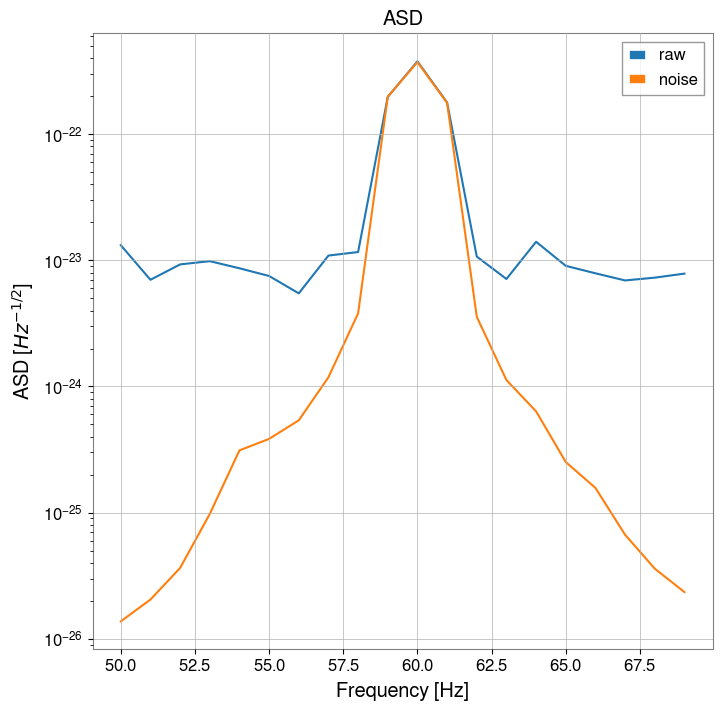

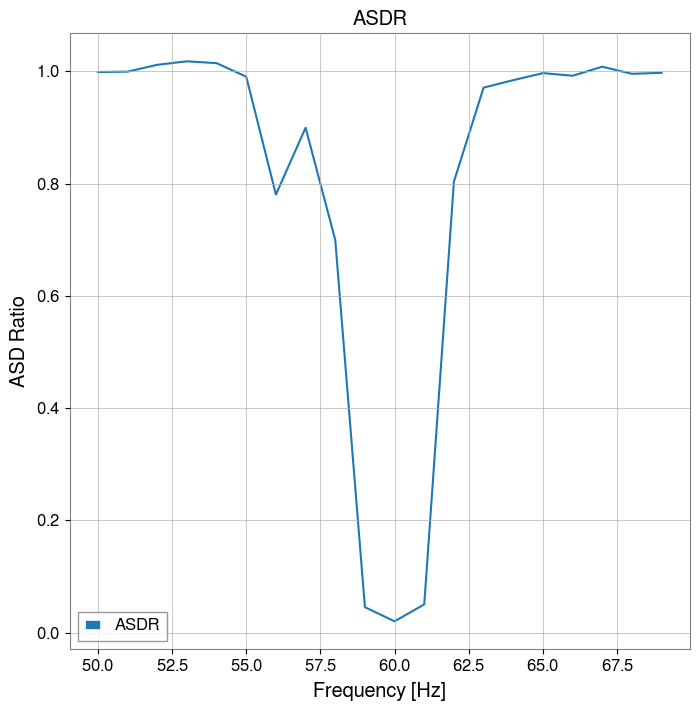

In [ ]:
# start, stop = int(0*sample_rate), int(noise.shape[1]/sample_rate*sample_rate)
# start, stop = int(0*128*sample_rate), int(1*128*sample_rate)
start, stop = int(0*sample_rate), int(3*sample_rate)
noise_ts = TimeSeries(
    noise[0][start:stop],
    t0=t0,
    sample_rate=sample_rate,
)
raw_ts = TimeSeries(
    raw[0][start:stop],
    t0=t0,
    sample_rate=sample_rate,
)
cleaned = raw[0][start:stop] - noise[0][start:stop]
print(noise[0, start:stop])
cleaned_ts = TimeSeries(
    cleaned.cpu().numpy(),
    t0=t0,
    sample_rate=sample_rate,
)

# fftlength = 32
fftlength = 1
overlap = fftlength/2
noise_asd = noise_ts.asd(
    fftlength=fftlength,
    overlap=overlap,
    method='median',
)
raw_asd = raw_ts.asd(
    fftlength=fftlength,
    overlap=overlap,
    method='median',
)
cleaned_asd = cleaned_ts.asd(
    fftlength=fftlength,
    overlap=overlap,
    method='median',
)
flow, fhigh = 50, 70
df = 1/fftlength
fidx_low, fidx_high = int(flow/df), int(fhigh/df)
plt.figure(figsize=[8,8])
plt.plot(raw_asd[fidx_low:fidx_high].frequencies, raw_asd[fidx_low:fidx_high], label='raw')
plt.plot(noise_asd[fidx_low:fidx_high].frequencies, noise_asd[fidx_low:fidx_high], label='noise')
plt.title('ASD')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'ASD [$Hz^{-1/2}$]')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=[8,8])
plt.plot(raw_asd[fidx_low:fidx_high].frequencies, cleaned_asd[fidx_low:fidx_high]/raw_asd[fidx_low:fidx_high], label='ASDR')
plt.title('ASDR')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD Ratio')
# plt.yscale('log')
plt.legend()
plt.show()

In [24]:
# output_file = f"{train_dir}/test/outputs.hdf5"
# with h5py.File(output_file, 'r') as f:
#     print(f.keys())
#     noise_strain = f['noise'][0][:]
#     raw_strain = f['strain'][0][:]

# start, stop = int(7*128*sample_rate), int(8*128*sample_rate)
# r_ts = TimeSeries(
#     raw_strain[start:stop],
#     t0=t0,
#     sample_rate=sample_rate,
# )
# n_ts = TimeSeries(
#     noise_strain[start:stop],
#     t0=t0,
#     sample_rate=sample_rate,
# )
# c_ts = r_ts - n_ts

# fftlength = 32
# overlap = fftlength/2
# n_asd = n_ts.asd(
#     fftlength=fftlength,
#     overlap=overlap,
#     method='median',
# )
# r_asd = r_ts.asd(
#     fftlength=fftlength,
#     overlap=overlap,
#     method='median',
# )
# c_asd = c_ts.asd(
#     fftlength=fftlength,
#     overlap=overlap,
#     method='median',
# )
# flow, fhigh = 40, 80
# df = 1/fftlength
# fidx_low, fidx_high = int(flow/df), int(fhigh/df)
# plt.figure(figsize=[8,8])
# plt.plot(r_asd[fidx_low:fidx_high].frequencies, r_asd[fidx_low:fidx_high], label='raw')
# plt.plot(n_asd[fidx_low:fidx_high].frequencies, n_asd[fidx_low:fidx_high], label='noise')
# plt.title('ASD')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel(r'ASD [$Hz^{-1/2}$]')
# plt.yscale('log')
# plt.legend()
# plt.show()

# plt.figure(figsize=[8,8])
# plt.plot(r_asd[fidx_low:fidx_high].frequencies, c_asd[fidx_low:fidx_high]/r_asd[fidx_low:fidx_high], label='ASDR')
# plt.title('ASDR')
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('ASD Ratio')
# # plt.yscale('log')
# plt.legend()
# plt.show()

### Online inference

In [14]:
device = "cuda"
sample_rate = clean_config['sample_rate']
outdir = clean_config['outdir']
train_dir = clean_config['train_dir']

train_start, train_duration = 1250916844, 4096
test_start = train_start + train_duration
t0 = test_start + 2

# InferenceModel
inference_model = InferenceModel(
    train_dir=train_dir,
    sample_rate=sample_rate,
    device=device,
)

# DeepCleanInferenceDataset
hoft_dir = clean_config['hoft_dir']
witness_dir = clean_config['witness_dir']
batch_size = 32
inference_sampling_rate = 2
kernel_size = 1
inference_dataset = DeepCleanInferenceDataset(
    hoft_dir=hoft_dir,
    witness_dir=witness_dir,
    model=inference_model,
    device=device,
)

# OnlineInference
online_infer = OnlineInference(
    model=inference_model,
    device=device,
    dataset=inference_dataset,
    outdir=outdir,
)

In [15]:
infer_pred = online_infer.predict()
infer_noise, infer_raw, infer_cleaned = online_infer.postprocess()

tensor([[-0.5168, -0.3772, -0.4697,  ..., -0.2916, -0.6483, -0.1688],
        [-0.5054, -0.3865, -0.4847,  ..., -0.2982, -0.6587, -0.1671],
        [-0.5152, -0.3781, -0.4707,  ..., -0.2975, -0.6577, -0.1679],
        [-0.5044, -0.3869, -0.4855,  ..., -0.2972, -0.6559, -0.1674],
        [-0.5034, -0.3871, -0.4858,  ..., -0.2899, -0.6433, -0.1561]],
       device='cuda:0', grad_fn=<SelectBackward0>)


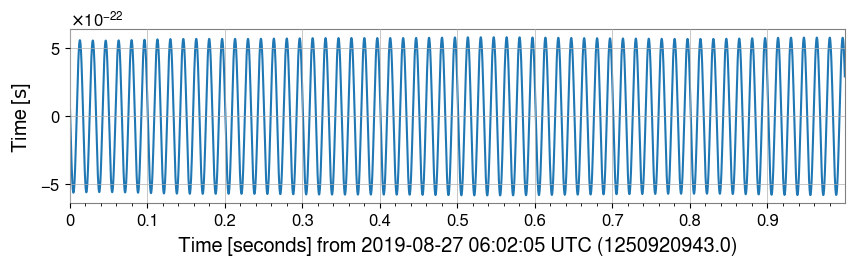

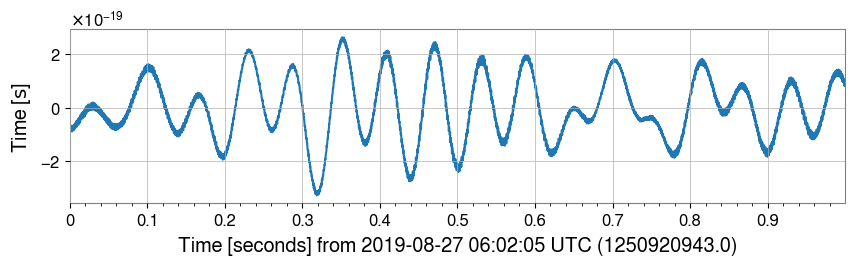

In [17]:
infer_noise.plot(figsize=[10,3]).show()
infer_raw.plot(figsize=[10,3]).show()

torch.Size([10648])


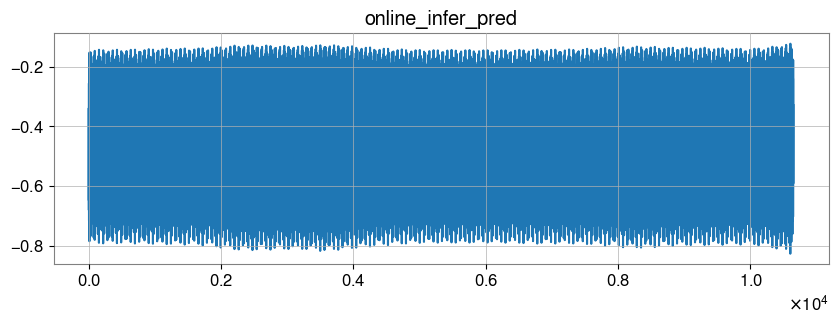

torch.Size([8189, 10648])


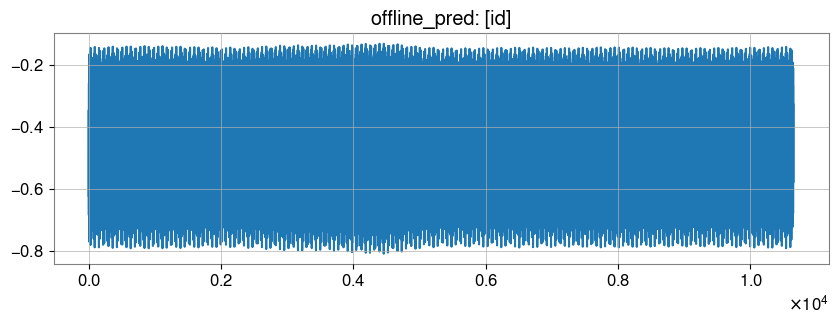

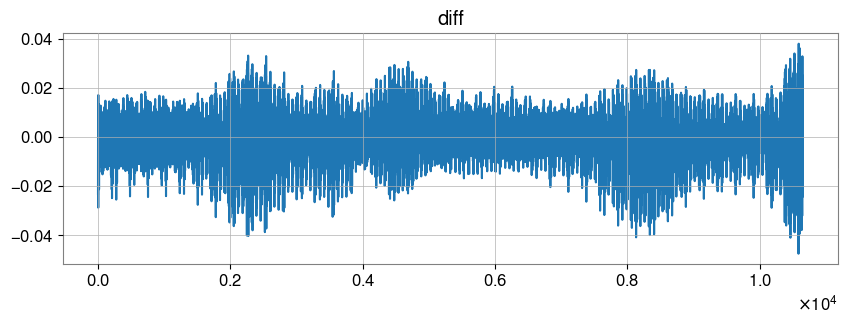

In [43]:
print(infer_pred.shape)
plt.figure(figsize=[10,3])
plt.title('online_infer_pred')
plt.plot(infer_pred.double().to('cpu').detach().numpy())
plt.show()

id = 4
print(noise_before_process.shape)
plt.figure(figsize=[10,3])
plt.title(f'offline_pred: [id]')
plt.plot(noise_before_process[id, :].double().to('cpu').detach().numpy())
plt.show()

diff = infer_pred.double().to('cpu').detach().numpy() - noise_before_process[id, :].double().to('cpu').detach().numpy()
plt.figure(figsize=[10,3])
plt.title('diff')
plt.plot(diff)
plt.show()

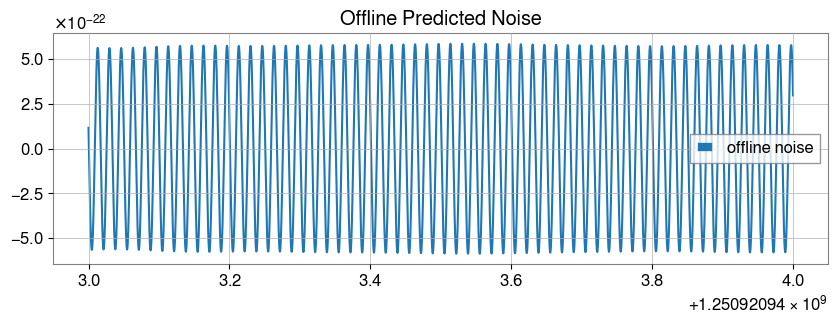

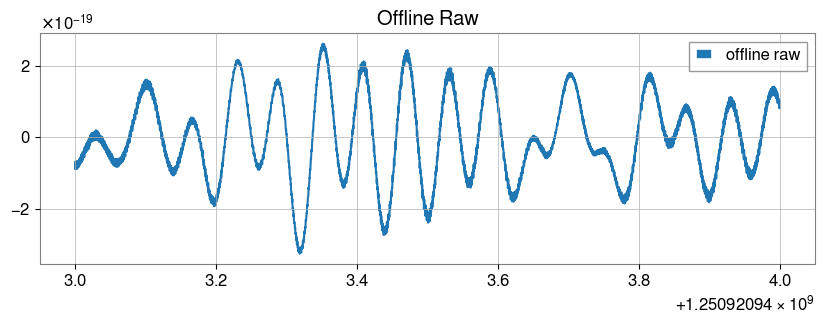

In [35]:
st = 2
plt.figure(figsize=[10,3])
plt.title("Offline Predicted Noise")
plt.plot(times[st*fs: (st+1)*fs], noise[0,st*fs:(st+1)*fs], label="offline noise")
plt.legend()
plt.show()

plt.figure(figsize=[10,3])
plt.title("Offline Raw")
plt.plot(times[st*fs: (st+1)*fs], raw[0,st*fs:(st+1)*fs], label="offline raw")
plt.legend()
plt.show()

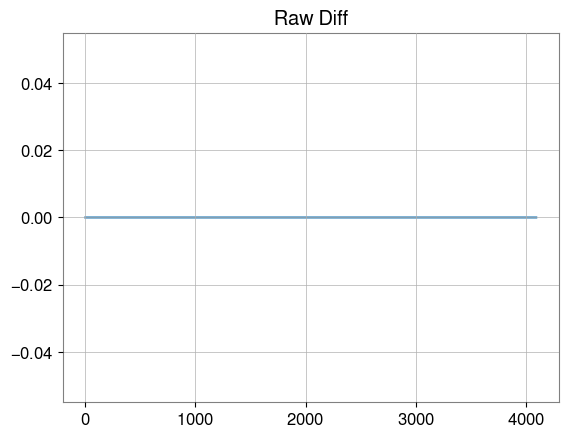

In [41]:
raw_diff = raw[0, st*fs:(st+1)*fs].double().to('cpu').numpy() - infer_raw.value
plt.figure()
plt.title("Raw Diff")
plt.plot(raw_diff)
plt.show()